In [1]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:5000px;
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

Задачи:

Сделать возможность получения данных в зависимости от числа переменных ФАЛ и объёма исследования:
- Сложность схемы
- Глубина схемы
- Время синтеза

Изобразить графики.

Попытаться теоритически обосновать какие-нибудь оценки сложности схем и данного алгоритма.

In [2]:
import numpy as np
import copy
import time

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

In [3]:
def make_Karno_size(variables):
    """
    ============================================================
    В  зависимости от числа переменных выдаёт размер карты Карно
    ============================================================
    """
    for x in range(0, variables // 2):
        yield 4
    if variables % 2 != 0:
        yield 2
        
def put_TT(variables):
    """
    ==========================================================
    Загружает в специальный файл вектор значений случайной ФАЛ
    ==========================================================
    """
    f = open('random_Karno.txt', 'w')
    r = np.random.randint(0, 2, np.power(2, variables))
    for i in range(np.power(2, variables)):
        f.write(str(r[i]))
    f.close()
    
def slice_list_extractor(a, b):
    """
    ==================================
    Позволяет распаковать набор срезов
    ==================================
    """
    if b == []:
        yield np.array(a)
    else:
        for i in range(b[0].start, b[0].stop):
            c = copy.copy(b)
            c.pop(0)
            for j in slice_list_extractor(a + [i], c):
                yield j

In [4]:
class Karno_Field:
    """
    ===========
    ===========
    Карта Карно
    ===========
    ===========
    
    
    Аттрибуты:
    - self.variables - число переменных ФАЛ
    - self.Karno_size - распределение размеров карты Карно
    - self.field - карта Карно
    - self.curr_coord - координаты текущей единицы
    - self.extended_field - расширенная на 1 слой карта Карно
    - self.origin_field - копия карты Карно
    - self.scores - очки за (не-)помеченные единицы
    - self.extended_scores - расширенное поле очков
    - self.fal_vector - вектор значений ФАЛ (для теста)
    """
    def __init__(self, variables, file=None, to_random=False):
        """
        ================================================================================
        Строит Карту Карно для заданного вектора значений ФАЛ (рандомной или через файл)
        ================================================================================
        """
        self.variables = variables
        self.Karno_size = tuple(make_Karno_size(variables))
        if file is None: 
            self.field = np.random.randint(0, 2, self.Karno_size)
            array1 = copy.copy(self.field)
            self.fal_vector = self.Karno_renderer(array1).reshape(-1)
            if to_random:
                f = open('random_Karno.txt', 'w')
                f.write(''.join(list(np.array(self.fal_vector, dtype=str))))
                f.close()
        else:
            f = open(file, 'r')
            array1 = np.array(list(''.join(f.read().split('\n'))[:np.power(2, variables)]), dtype='int').reshape(self.Karno_size)
            f.close()
            self.fal_vector = copy.copy(array1.reshape(-1))
            self.field = self.Karno_renderer(array1)
        
        if len(np.unique(self.fal_vector)) == 1:
            raise Exception(">>> My maker's message for you!\n >>> You are trying to take a constant cheme. Plese, don't make me do that! I'm terrified with it!\n")
        self.origin_field = copy.copy(self.field)
        self.scores = copy.copy(self.field)
        self.scores *= 2
        
    def Karno_renderer(self, a):
        """
        ===================================================================================================
        Позволяет преобразовывать матрицу значений ФАЛ в карту Карно (необходимо менять порядок переменных)
        ===================================================================================================
        """
        slice04 = slice(0, 4)
        slice02 = slice(0, 2)
        slice2 = 2
        slice3 = 3
        superslice = [slice04 for i in range(len(self.Karno_size))]
        superslice[-1] = slice02 if self.Karno_size[-1] == 2 else slice04 
        for i in range(len(self.Karno_size[:-1])):
            localslice1, localslice2 = superslice[:], superslice[:]
            localslice1[i], localslice2[i] = slice2, slice3 
            a[tuple(localslice1)], a[tuple(localslice2)] = copy.copy(a[tuple(localslice2)]), copy.copy(a[tuple(localslice1)])
        if self.Karno_size[-1] == 4:
            localslice1, localslice2 = superslice[:], superslice[:]
            localslice1[-1], localslice2[-1] = slice2, slice3
            a[tuple(localslice1)], a[tuple(localslice2)] = copy.copy(a[tuple(localslice2)]), copy.copy(a[tuple(localslice1)])
        return a
            
    def choice_one(self):
        """
        ======================================================================================
        Наугад выбирает одну единицу из карты Карно и помещает её координаты в self.curr_coord
        ======================================================================================
        """
        if len(self.field[self.field != 0]) == 0:
            return None
        b = np.random.choice(np.arange(len(self.field.reshape(-1)))[self.field.reshape(-1) == 1])
        buf = np.prod(self.Karno_size)
        res = []
        for i in range(0, len(self.Karno_size)):
            buf //= self.field.shape[i]
            res = res + [b // buf]
            b %= buf
        self.curr_coord = res
        
    def make_extended_Karno(self):
        """
        ====================================================================================================
        Расширяет карту Карно на 1 слой и присваивает расширенную карту Карно переменной self.extended_field
        Расширяет поле очков на 1 слой и присваивает переменной self.extended_scores
        ====================================================================================================
        """
        matr = [self.field, self.scores]
        extenders = []
        for m in matr:
            buf = np.array(self.Karno_size) + 2
            blank = np.zeros(np.prod(buf)).reshape(buf)
            superslice = [slice(1, 5) for i in range(len(self.Karno_size) - 1)] + [slice(1, self.Karno_size[-1] + 1)]
            blank[tuple(superslice)] = m
        
            # копирование по граням слоя
            for i in range(len(self.Karno_size)):
                localslice1, localslice2 = superslice[:], superslice[:]
                localslice1[i], localslice2[i] = 0, self.Karno_size[i]
                blank[tuple(localslice1)] = copy.copy(blank[tuple(localslice2)])
                localslice1[i], localslice2[i] = self.Karno_size[i] + 1, 1 
                blank[tuple(localslice1)] = copy.copy(blank[tuple(localslice2)])
                
            # копирование оставшихся вершин
            for i in range(np.power(2, len(self.Karno_size))):
                j = i
                k = len(self.Karno_size)
                localslice1, localslice2 = [], []
                while k > 1:
                    localslice1 += [5*(j % 2)]
                    localslice2 += [4 - 3*(j % 2)]
                    j //= 2
                    k -= 1
                localslice1 += [(self.Karno_size[-1] + 1)*(j % 2)]
                localslice2 += [self.Karno_size[-1] - (self.Karno_size[-1] - 1) * (j % 2)]
                blank[tuple(localslice1)] = copy.copy(blank[tuple(localslice2)])
            extenders += [blank]
            
        self.extended_field = extenders[0]
        self.extended_scores = extenders[1]

In [5]:
class Karno_General(Karno_Field):
    """
    =============
    =============
    Перевод в ДНФ
    =============
    =============
    
    ========================================================================
    Абстрактный. Принимает карту Карно, строит минимальную ДНФ через векторы
    ========================================================================
    
    Аттрибуты:
    - self.origin_acts - множество команд редуцирования
    - self.curr_edges - текущее распределение граней
    - self.best_edges - лучшее распределение граней
    - self.best_score - счёт лучших граней
    """
    def __init__(self, variables, file=None, to_random=False):
        super().__init__(variables, file, to_random)
        self.origin_acts = np.arange(2 * len(self.Karno_size))
        self.make_extended_Karno()
        
    def reduce(self, comand):
        """
        ==============
        Редукция грани
        ==============
        """
        if self.curr_edges.reshape(-1)[comand] == 4 or self.curr_edges.reshape(-1)[comand] == 2:
            self.curr_edges = self.curr_edges.reshape(-1)
            self.curr_edges[comand] -= 1
            self.curr_edges = self.curr_edges.reshape((2, -1))
        else:
            self.curr_edges = self.curr_edges.reshape(-1)
            self.curr_edges[comand] //= 2
            self.curr_edges = self.curr_edges.reshape((2, -1))
            
    def maintain(self, comand):
        """
        =========================================
        Наращивание грани (без 3 и 4, пожалуйста)
        =========================================
        """
        if self.curr_edges.reshape(-1)[comand] == 2 or self.curr_edges.reshape(-1)[comand] == 0:
            self.curr_edges = self.curr_edges.reshape(-1)
            self.curr_edges[comand] += 1
            self.curr_edges = self.curr_edges.reshape((2, -1))
        else:
            self.curr_edges = self.curr_edges.reshape(-1)
            self.curr_edges[comand] += 2
            self.curr_edges = self.curr_edges.reshape((2, -1))
            
    def find_curr_score(self):
        superslice = [slice((np.array(self.curr_coord) - np.array(self.curr_edges[0], dtype=int) + 1)[i], (np.array(self.curr_coord) + np.array(self.curr_edges[1], dtype=int) + 2)[i]) for i in range(len(self.Karno_size))]
        return np.sum(self.extended_scores[tuple(superslice)])
    
    def find_best_score(self):
        superslice = [slice((np.array(self.curr_coord) - np.array(self.best_edges[0], dtype=int) + 1)[i], (np.array(self.curr_coord) + np.array(self.best_edges[1], dtype=int) + 2)[i]) for i in range(len(self.Karno_size))]
        return np.sum(self.extended_scores[tuple(superslice)])
    
    def kpd(self):
        """
        ====================================================
        Возвращает долю единиц среди элементов текущей грани
        ====================================================
        """
        superslice = [slice((np.array(self.curr_coord) - np.array(self.curr_edges[0], dtype=int) + 1)[i], (np.array(self.curr_coord) + np.array(self.curr_edges[1], dtype=int) + 2)[i]) for i in range(len(self.Karno_size))]
        score = self.extended_scores[tuple(superslice)]
        return np.count_nonzero(score != 0) / np.prod(score.shape)
    
    def choice_acts(self, n, typ='reduce'):
        """
        ============================================
        Наугад выбирает n разных допустимых действий
        ============================================
        """
        if typ == 'reduce':
            if len(self.curr_edges[self.curr_edges != 0]) < n:
                n = len(self.curr_edges[self.curr_edges != 0])
            return np.random.choice(self.origin_acts[self.curr_edges.reshape(-1) != 0], n, replace=False)
        else:
            domain_acts1 = self.origin_acts[:len(self.origin_acts) // 2]
            mask1 = np.array(self.curr_coord) + 1 - self.curr_edges[0] > 0
            mask2 = self.curr_edges[0] < 3
            mask3 = self.curr_edges[0] != 1  
            mask4 = np.array(self.curr_coord) != 1
            mask = mask1 & mask2 & (mask3 | mask4)
            domain_acts1 = domain_acts1[mask]

            domain_acts2 = self.origin_acts[(len(self.origin_acts) // 2):] # !!! ???
            mask1 = self.curr_edges[1] + np.array(self.curr_coord) < np.array(self.Karno_size)
            mask2 = self.curr_edges[1] < np.array(self.Karno_size) - 1
            mask3 = self.curr_edges[1] != 1
            mask4 = np.array(self.curr_coord) != 2
            mask = mask1 & mask2 & (mask3 | mask4)
            domain_acts2 = domain_acts2[mask]
            
            domain_acts = np.concatenate((domain_acts1, domain_acts2))
                
            if len(domain_acts) == 0:
                return None
            if len(domain_acts) < n:
                n = len(domain_acts)
            return np.random.choice(domain_acts, n, replace=False)
        
    def micro_ascend(self, attempts=10):
        """
        ============================================
        Опциональные попытки расширения лучшей грани
        ============================================
        """
        for att in range(attempts):
            self.curr_edges = copy.copy(self.best_edges)
            act_pretenders = self.choice_acts(len(self.Karno_size), 'maintain')
            buf = copy.copy(self.curr_edges)
            for act in act_pretenders:
                self.maintain(act)
                if self.kpd() == 1:
                    self.best_edges = copy.copy(buf)
                    self.best_score = self.find_best_score()
                break
                
    def best_rend(self): # !!!!!
        """
        ====================================
        Редукция грани с размером в 3 клетки
        ====================================
        """
        buf = copy.copy(self.best_edges)
        for i in np.arange(len(self.Karno_size))[np.sum(self.best_edges, axis=0) == 2]:
            self.curr_edges = copy.copy(buf)
            self.reduce(self.origin_acts.reshape((2, -1))[0, i])
            score1 = self.find_curr_score()
            
            self.curr_edges = copy.copy(buf)
            self.reduce(self.origin_acts.reshape((2, -1))[1, i])
            score2 = self.find_curr_score()
            
            if score2 >= score1:
                self.best_edges = copy.copy(self.curr_edges)
            else:
                self.curr_edges = copy.copy(buf)
                self.reduce(self.origin_acts.reshape((2, -1))[0, i])
                self.best_edges = copy.copy(self.curr_edges)
            buf = copy.copy(self.best_edges)
    
    def best_vector(self):
        """
        =================================
        Перевод грани в вектор переменных
        =================================
        """
        helper1 = np.array([[1, -1], [-1, -1], [-1, 1], [1, 1], [1, -1], [-1, -1]], dtype=int)
        summa = np.sum(self.best_edges, axis=0, dtype=int)
        absolute_edges = np.concatenate((np.array(self.curr_coord) - self.best_edges[0] + 1, np.array(self.curr_coord) + self.best_edges[1] + 1), axis=0).reshape(2, -1)
        absolute_edges = np.array(absolute_edges, dtype=int)
        blank = np.zeros(((self.variables + 1) // 2, 2)) # если их нечётное число
        blank[summa.T == 0] = helper1[np.array(self.curr_coord, dtype=int)[np.arange(len(summa))[summa == 0]] + 1]
        blank[summa.T == 1] = ((helper1[absolute_edges[0, summa == 1]] + helper1[absolute_edges[1, summa == 1]]) // 2).reshape((-1, 2))
        
        if self.variables % 2 == 1:
            if np.sum(self.best_edges[:, -1]) == 0:
                blank[-1, 0] = -1 if self.curr_coord[-1] == 0 else 1
            else: 
                blank[-1, 0] = 0
            blank = blank.reshape(-1)[:-1]
        else:
            blank = blank.reshape(-1)
        return blank
    
    def little_exploit_generator(self, coord):
        """
        ===================================================================
        Получает координаты coord одной из точек на расширенной карте Карно 
        Возвращает набор всех координат, совпадающих с данной
        ===================================================================
        """
        """
        coord[coord > 3] -= 4
        for i in range(np.power(2, len(coord[coord < 2]))):
            buf = np.zeros_like(coord)
            j = i
            k = len(coord[coord < 2])
            while k != 0:
                buf[np.arange(len(buf))[coord < 2][k - 1]] = (j % 2)
                j //= 2
                k -= 1
            yield 4 * np.array(buf) + coord
        """
        
        if self.variables % 2 == 1:
            if coord[-1] > 1:
                last_coord = coord[-1] - 2
            else:
                last_coord = coord[-1]
            coord = coord[:-1]
        coord[coord > 3] -= 4
        for i in range(np.power(2, len(coord[coord < 2]))):
            buf = np.zeros_like(coord)
            j = i
            k = len(coord[coord < 2])
            while k != 0:
                buf[np.arange(len(buf))[coord < 2][k - 1]] = (j % 2)
                j //= 2
                k -= 1
            if self.variables % 2 == 1:
                yield np.array(list(4 * np.array(buf) + coord) + [last_coord])
                yield np.array(list(4 * np.array(buf) + coord) + [last_coord + 2])
            else:
                yield 4 * np.array(buf) + coord
            
    def great_exploit_generator(self):
        """
        =======================================================================
        Выдаёт все точки расширенной карты Карно, соответствующие текущей грани
        =======================================================================
        """
        result = set()
        superslice = [slice((np.array(self.curr_coord) - np.array(self.best_edges[0], dtype=int) + 1)[i], (np.array(self.curr_coord) + np.array(self.best_edges[1], dtype=int) + 2)[i]) for i in range(len(self.Karno_size))]
        for i in slice_list_extractor([], superslice):
            for j in self.little_exploit_generator(i):
                result.add(tuple(j))
        return result
    
    def exploit(self):
        """
        ======================
        Обработка лучшей грани
        ======================
        """
        for i in self.great_exploit_generator():
            self.extended_scores[i] = 1
            self.extended_field[i] = 0
        superslice = [slice(1, 5) for i in range(len(self.Karno_size) - 1)] + [slice(1, self.Karno_size[-1] + 1)]
        self.field = self.extended_field[tuple(superslice)]

In [6]:
class Karno_Agent1(Karno_General):
    """
    =======================================================================================================
    1 нисходящий поиск по локальной максимизации КПД + последовательность эксплорирования в его окрестности
    =======================================================================================================
    
    Аттрибуты:
    - self.origin_acts - множество команд
    - self.curr_edges - текущее распределение граней
    - self.best_reduce_seq - лучшая последовательность действий (текущая)
    - self.best_edges - лучшая конфигурация граней
    """
    def __init__(self, variables, file=None, to_random=False):
        super().__init__(variables, file, to_random)
    
    def change_act(self, exc):
        """
        ======================================================
        Наугад выбирает допустимое действие за исключением exc
        ======================================================
        """
        return np.random.choice(np.delete(self.origin_acts, exc)[np.delete(self.curr_edges.reshape(-1), exc) != 0], 1, replace=False)
    
    def find_first_rect(self, subbranches=None):
        """
        =================================================================================
        Определяет макисмальную грань для единицы с self.curr_coord - первое приближение, 
        засовывает действия в self.best_reduce_seq
        =================================================================================
        
        Параметры:
        - subbranches - число ветвлений на каждом шаге (по умолчанию фулл)
        """
        self.origin_acts = copy.copy(self.origin_acts)
        self.origin_edges = np.concatenate(((np.array(self.curr_coord) + 1)[np.newaxis, :], (np.array(self.curr_coord)*(-1) + 4)[np.newaxis, :]), axis=0)
        self.origin_edges[1, -1] -= (4 - self.Karno_size[-1])
        self.origin_edges[self.origin_edges == 2] = 1
        self.origin_edges[self.origin_edges == 4] = 3
        self.curr_edges = copy.copy(self.origin_edges)
        self.best_reduce_seq = []
        if subbranches is None:
            subbranches = 2 * len(self.Karno_size)
        while self.kpd() != 1:
            act_pretenders = self.choice_acts(subbranches)
            buf_edges = copy.copy(self.curr_edges)
            kpds = []
            for act in act_pretenders:
                self.reduce(act)
                kpds += [self.kpd()]
                self.curr_edges = copy.copy(buf_edges)
            best_act = np.argmax(np.array(kpds))
            self.best_reduce_seq += [best_act] 
            self.reduce(act_pretenders[best_act])
        self.curr_edges[(self.curr_edges == 2) | (self.curr_edges == 4)] -= 1
        self.best_edges = self.curr_edges
        self.best_score = self.find_best_score()
    
    def exploration(self, threshold=0.5):
        """
        ================================================================
        Поиск в окрестности лучшей конфигурации по нисходящей траектории
        ================================================================
        """
        self.curr_edges = copy.copy(self.origin_edges)
        k = 0
        curr_seq = []
        while self.kpd() != 1 and k != len(self.best_reduce_seq):
            r = np.random.sample()
            if r > threshold:
                act = self.change_act(self.best_reduce_seq[k])
            else:
                act = self.best_reduce_seq[k]
            self.reduce(act)
            curr_seq += [act]
            k += 1
        self.curr_edges[(self.curr_edges == 2) | (self.curr_edges == 4)] -= 1
        
        if self.kpd() == 1 and self.find_curr_score() > self.best_score:
            self.best_reduce_seq = curr_seq
            self.best_edges = self.curr_edges
            self.best_score = self.find_best_score()
            
    def exploration_sequence(self, number=100, threshold=0.5):
        """
        ============================
        Многократное эксплорирование
        ============================
        """
        for i in range(number):
            try:
                self.exploration(threshold)
            except ValueError:
                pass
    
    def Karno_to_vectors(self, explore_numbers=10):
        """
        =================
        Получение всех ЭК
        =================
        """
        result = []
        while np.count_nonzero(self.extended_field != 0) != 0:
            self.choice_one()
            self.find_first_rect()
            self.exploration_sequence(explore_numbers)        
            self.best_rend()
            bv = self.best_vector()            
            result += list(bv)
            self.exploit()
        return np.array(result).reshape((-1, self.variables))

In [7]:
class Karno_Agent2(Karno_General):
    """
    =========================================
    Поиск лучшей грани крюковым брутфорсингом
    =========================================
    
    
    Аттрибуты:
    - self.origin_acts - множество команд редуцирования
    - self.curr_edges - текущее распределение граней
    - self.best_edges - лучшая конфигурация граней
    """
    def __init__(self, variables, file=None, to_random=False):
        super().__init__(variables, file, to_random)
            
    def initialize(self):
        """
        =====================================================================
        Предварительная обработка для каждой выбранной единицы на карте Карно
        =====================================================================
        """
        self.origin_edges = np.concatenate(((np.array(self.curr_coord) + 1)[np.newaxis, :], (np.array(self.curr_coord)*(-1) + 4)[np.newaxis, :]), axis=0)
        self.origin_edges[1, -1] -= (4 - self.Karno_size[-1])
        self.origin_edges[self.origin_edges == 2] = 1
        self.origin_edges[self.origin_edges == 4] = 3
        self.curr_edges = copy.copy(self.origin_edges)
        self.best_edges = np.zeros(2 * len(self.Karno_size)).reshape(2, -1)
        self.best_score = self.find_best_score()
        
    def descend(self):
        """
        =============================
        Низконаправленный брутфорсинг
        =============================
        """
        while self.kpd() != 1:
            self.reduce(self.choice_acts(1))
        if self.kpd() == 1 and np.sum(self.curr_edges) > np.sum(self.best_edges):
            self.best_edges = copy.copy(self.curr_edges)
            self.best_score = self.find_best_score()
    
    def ascend(self):
        """
        ==============================
        Верхненаправленный брутфорсинг
        ==============================
        """
        act = self.choice_acts(1, 'maintain')
        while self.kpd() == 1 and not (act is None):
            buf = copy.copy(self.curr_edges)
            self.maintain(act)
            act = self.choice_acts(1, 'maintain')
        self.curr_edges = copy.copy(buf)
        
        if self.find_curr_score() > self.best_score:
            self.best_edges = copy.copy(buf)
            self.best_score = self.find_best_score()
            
    def desasc_sequence(self, number=10):
        """
        ===========================
        Последовательность "крюков"
        ===========================
        """
        for i in range(number):
            self.curr_edges = copy.copy(self.origin_edges)
            self.descend()
            self.ascend()
            
    def Karno_to_vectors(self, explore_numbers=10):
        """
        =================
        Получение всех ЭК
        =================
        """
        result = []
        while np.count_nonzero(self.extended_field != 0) != 0:
            self.choice_one()
            self.initialize()
            self.desasc_sequence(explore_numbers)
            self.best_rend()
            result += list(self.best_vector())
            self.exploit()
        return np.array(result).reshape((-1, self.variables))

In [8]:
global_sh = 100

class Maj:
    def __init__(self, DNF=np.array([[]]), typ="regular", sh=global_sh):
        """
        ====================================================
        ====================================================
        Перевод ДНФ в схему (оптимальную в некотором смысле)
        Каждый объект класса - мажоритарный элемент
        ====================================================
        ====================================================
        
        
        Атрибуты:
        - self.DNF - Локальная ДНФ, которую должен реализовать элемент с его наддеревом (много памяти)
        - self.incomplete_DNF - часть ДНФ, ещё не распределённая по группам (много памяти)
        - self.incomplete_row - индексы ЭК, ещё не распределённых по группам
        - self.variables - число переменных реализуемой ФАЛ
        - self.fal_vector - вектор значений функции
        - self.shift - сдвиг для представления входных БП
        
        - self.groups - словарь с распределёнными группами
        - self.group_index - индекс грядущей новой группы
        - self.typ - "regular" / "irregular" (второе не контролируется) - тип реализации мажоритарного элемента:
                         "regular" - элемент содержит неразделённые по группам ЭК, их необходимо разделить и
                             рекурсивно реализовывать, пока группы не распадутся
                         "irregular" - элемент входит в рекурсивную цепочку реализации совокупности групп
        
        - self.value - для конечных элементов реализация констант и БП
        - self.arg1 - первый аргумент элемента
        - self.arg2 - второй аргумент элемента
        - self.arg3 - третий аргумент элемента
        - self.back - элемент, для которого данный объект является аргументом
        
        
        =============================================================================================================
        Алгоритм:
        Группа - множество ЭК, содержащих по крайней мере 1 общую БП. Распределение по группам происходит 
        жадным способом - как можно больше нераспределённых ЭК в одну группу.
        Если ДНФ для текущего элемента не разделена по группам - разделить.
        Рекурсивно дизюънктировать группы, пока для верхних элементов не останется только по 1 группе для реализации.
        Внутри 1 группы отделить конъюнкцией общую букву. Оставшиеся ЭК обработать тем же методом, вновь производя
        разделение по группам.
        =============================================================================================================
        """
        self.DNF = DNF
        self.incomplete_DNF = copy.copy(self.DNF)
        self.incomplete_row = np.arange(self.DNF.shape[0])
        self.variables = self.DNF.shape[1]
        
        self.value = None
        self.arg1 = None
        self.arg2 = None
        self.arg3 = None
        self.back = None
        self.shift = sh
        self.groups = {}
        self.group_index = 1
        self.typ = typ
       
    """
    =====================================================================================
                                                        Методы сеттинга-клиринга
    =====================================================================================
    """
    def put_value(self, value):
        self.value = value
        return self
    
    def put_groups(self, groups):
        self.groups = groups
        return self
    
    def put_fal_vector(self, fal_vector):
        self.fal_vector = fal_vector
    
    def clear(self):
        self.DNF = self.incomplete_DNF = self.groups = self.typ = self.ground_index = None
    """
    ======================================================================================
    """    
    
        
    def find_group(self):
        """
        =================================================
        Отделить ЭК из self.incomplete_DNF в новую группу
        =================================================
        """
        if np.count_nonzero(self.incomplete_DNF != 0) == 0:
            return None
        positives = np.count_nonzero(self.incomplete_DNF == 1, axis=0)
        negatives = np.count_nonzero(self.incomplete_DNF == -1, axis=0)
        similarity_rating = np.concatenate((positives, negatives), axis=0)
        most_common = np.argmax(similarity_rating)
        if most_common < self.variables:
            group1 = np.arange(self.incomplete_DNF.shape[0])[self.incomplete_DNF[:, most_common % self.variables] == 1]
        else: 
            group1 = np.arange(self.incomplete_DNF.shape[0])[self.incomplete_DNF[:, most_common % self.variables] == -1]
        group2 = group1
        group1 = self.incomplete_row[group1]
        self.incomplete_row = np.delete(self.incomplete_row, group2)
        self.incomplete_DNF = np.delete(self.incomplete_DNF, group2, axis=0)[np.newaxis, :].reshape((-1, self.variables))
        self.groups[self.group_index] = group1
        self.group_index += 1
        return 0
        
    def find_all_groups(self):
        """
        ================
        Найти все группы
        ================
        """
        buf = 0
        while self.incomplete_DNF.shape[0] != 0 and not buf is None:
            buf = self.find_group()
        return buf
            
    def one_litera_some_AK(self):
        """
        ================================================
        Реализация одной группы: у всех ЭК есть общая БП
        ================================================
        """
        positives = np.count_nonzero(self.DNF == 1, axis=0)
        negatives = np.count_nonzero(self.DNF == -1, axis=0)
        similarity_rating = np.concatenate((positives, negatives), axis=0)
        most_common_value = np.max(similarity_rating)
        cols_with_max_value = np.arange(self.DNF.shape[1])[np.abs(np.sum(self.DNF, axis=0)) == most_common_value]
        max_values = self.DNF[0, cols_with_max_value]
        self.DNF[:, cols_with_max_value] = 0
        self.arg1 = copy.copy(Maj(self.DNF))
        buf = self.arg1.make_element()
        if buf != 0:
            self.typ = "regular"
            self.arg1 = None
            self.DNF = np.zeros(self.DNF.shape[1])
            self.DNF[cols_with_max_value] = max_values
            self.DNF = self.DNF[np.newaxis, :]
            self.put_groups({1: np.array([0])})
            self.one_group()
        else:
            self.typ = "regular"
            self.arg1.back = self
            local_DNF = np.zeros(self.DNF.shape[1])
            local_DNF[cols_with_max_value] = max_values
            local_DNF = local_DNF[np.newaxis, :]
            self.arg2 = copy.copy(Maj(local_DNF))
            self.arg2.put_groups({1: np.array([0])})
            self.arg2.one_group()
            self.arg2.back = self
            self.arg3 = copy.copy(Maj().put_value(0))
            self.arg3.back = self
        
        
    def one_AK(self):
        """
        =====================================================================
        Реализация одной ЭК - рекурсивное распределение конъюнкций - много БП
        =====================================================================
        """
        all_nonzeros = np.arange(self.variables)[self.DNF.reshape(-1) != 0]
        first_part_nonzeros = all_nonzeros[:(len(all_nonzeros) // 2)]
        second_part_nonzeros = all_nonzeros[(len(all_nonzeros) // 2):]
        first_DNF = np.zeros_like(self.DNF.reshape(-1))
        first_DNF[first_part_nonzeros] = self.DNF.reshape(-1)[first_part_nonzeros]
        second_DNF = np.zeros_like(self.DNF.reshape(-1))
        second_DNF[second_part_nonzeros] = self.DNF.reshape(-1)[second_part_nonzeros]
        
        self.arg1 = copy.copy(Maj(first_DNF[np.newaxis, :]))
        self.arg1.make_element()
        self.arg1.back = self
        self.arg2 = copy.copy(Maj(second_DNF[np.newaxis, :]))
        self.arg2.make_element()
        self.arg2.back = self
        self.arg3 = copy.copy(Maj().put_value(0))
        self.arg3.back = self
                    
    def some_AK_recurse(self, groups):
        """
        ===============================
        Реализация групп по дизъюнкциям
        ===============================
        """
        if len(groups) == 1:
            groups = list(groups.values())[0]
            self.DNF = self.DNF[groups]
            self.one_group()
        elif len(groups) == 2:
            self.arg1 = copy.copy(Maj(self.DNF, "irregular"))
            buf = {list(self.groups.keys())[0]: self.groups[list(self.groups.keys())[0]]}
            self.arg1.put_groups(buf)
            arg1_flag = self.arg1.make_element()
            self.arg1.back = self
            
            self.arg2 = copy.copy(Maj(self.DNF, "irregular"))
            buf = {list(self.groups.keys())[1]: self.groups[list(self.groups.keys())[1]]}
            self.arg2.put_groups(buf)
            arg2_flag = self.arg2.make_element()
            self.arg2.back = self
            
            self.arg3 = copy.copy(Maj().put_value(1))
            self.arg3.back = self
            
            if arg1_flag == None:
                return 1
            elif arg2_flag == None:
                return 2
            else:
                return 0
        else:
            self.arg1 = copy.copy(Maj(self.DNF, "irregular"))
            buf = {}
            length = 0
            full_length = 0
            for i in self.groups.values():
                full_length += len(i)
                
            while length < full_length // 2:
                key = list(self.groups.keys())[0]
                buf[key] = self.groups.pop(key)
                length += len(buf[key])
            self.arg1.put_groups(buf)
            self.arg1.make_element()
            self.arg1.back = self
            
            self.arg2 = copy.copy(Maj(self.DNF, "irregular"))
            self.arg2.put_groups(self.groups)
            self.arg2.make_element()
            self.arg2.back = self
            
            self.arg3 = copy.copy(Maj().put_value(1))
            self.arg3.back = self
        return 0
            
    def one_group(self):
        """
        =======================
        Реализация одной группы
        =======================
        """
        if len(list(self.groups.values())[0]) != 1: # У всех ЭК есть общая буква и ЭК несколько
            self.one_litera_some_AK()
        else: # одна ЭК
            flat_DNF = self.DNF.reshape(-1)
            if np.count_nonzero(flat_DNF != 0) == 1: # Одна буква
                self.value = ((int(np.arange(self.variables)[flat_DNF != 0])) + 1 + self.shift) * flat_DNF[flat_DNF != 0]
            elif np.count_nonzero(flat_DNF != 0) == 2: # Две буквы
                self.arg1 = copy.copy(Maj().put_value((int(np.arange(self.variables)[flat_DNF != 0][0]) + 1 + self.shift) * flat_DNF[flat_DNF != 0][0]))
                self.arg1.back = self
                self.arg2 = copy.copy(Maj().put_value((int(np.arange(self.variables)[flat_DNF != 0][1]) + 1 + self.shift) * flat_DNF[flat_DNF != 0][1]))
                self.arg2.back = self
                self.arg3 = copy.copy(Maj().put_value(0))
                self.arg3.back = self
            else: #  > 2 букв
                self.one_AK()
                
    def make_element(self):
        """
        ============================
        Реализация текущего элемента
        ============================
        """
        if self.typ == "regular":
            buf = self.find_all_groups()
            if buf is None:
                self.value = 0
                return None
            else:
                if self.group_index == 2: ## одна группа
                    self.one_group()
                else: ## Несколько групп
                    buf_recurse = self.some_AK_recurse(self.groups)
                    return buf_recurse
            self.clear()
        else:
            self.some_AK_recurse(self.groups)
            self.clear()
        return 0
    
    
    def show(self):
        """
        ===========
        Показ схемы
        ===========
        """
        if self.value != None:
            print(int(self.value), end=' ')
        else:
            print('(', end=' ')
            self.arg1.show()
            print('#', end=' ')
            self.arg2.show()
            print('#', end=' ')
            self.arg3.show()
            print(')', end=' ')
    
    def complexity(self):
        if self.value != None:
            return 0
        else:
            return self.arg1.complexity() + self.arg2.complexity() + self.arg3.complexity() + 1
        
    def depth(self):
        if self.value != None:
            return 0
        else:
            return np.max(np.array([self.arg1.depth(), self.arg2.depth(), self.arg3.depth()])) + 1
            
    def compute(self, x, variables): 
        """
        ===============================
        Вычисление схемы на наборе БП x
        ===============================
        """
        if self.value != None:
            if (self.value == 1) or (self.value == 0):
                return self.value
            if self.value > 0:
                return int((x & (1 << int(variables - (self.value - self.shift)))) != 0)
            else:
                return int((x & (1 << int(variables - (-self.value - self.shift)))) == 0)
        res1 = int(self.arg1.compute(x, variables))
        res2 = int(self.arg2.compute(x, variables))
        res3 = int(self.arg3.compute(x, variables))
        return (res1 & res2) ^ (res1 & res3) ^ (res2 & res3)
    
    def test(self, output=False, stop=False):
        """
        ==============
        Проверка схемы
        ==============
        """
        if output:
            print('\n')
            print('Res True')
        for i in range(np.power(2, self.variables)):
            res = self.compute(i, self.variables)
            if output:
                print(res, self.fal_vector[i])
            if res != self.fal_vector[i]:
                print('   !!!')    
                if stop:
                    return None
        return 0

In [9]:
def Make_scheme(variables, file=None, agent=1, scheme_output=True, output=True, exploration_number=10, to_random=False, testing=False):
    """
    =================================
    Обеспечивает всю функциональность
    =================================
    
    Параметры:
    - variables - число переменных ФАЛ
    - file - если None - берём случайную ФАЛ, иначе из файла с именем в переменной file
    - agent - 1 / 2 - номер агента для нахождения максимальных граней
    - scheme_output - вывод схемы и её параметров
    - output - вывод основных объектов при моделировании схемы
    - exploration_number - число итераций исследования агентами: 
                              у 1 агента - число вариаций отхода от идеальной стратегии,
                              у 2 агента - число "крюков" брутфорсинга
    - to_random - если True, то оставит вектор значений ФАЛ в файле 'random_Karno.txt'
    - testing - проверка корректности полученной схемы
    """
    if agent == 1:
        KA = Karno_Agent1(variables, file, to_random)
    elif agent == 2:
        KA = Karno_Agent2(variables, file, to_random)
    if output:
        print("====================\nFAL_vector:")
        print(KA.fal_vector)
        print("^^^^^^^^^^^^^^^^^^^^")
        print("====================\nKarno_field:")
        print(KA.field)
        print("^^^^^^^^^^^^^^^^^^^^")
        
    start = time.time()    
    DNF = KA.Karno_to_vectors(exploration_number)
    agent_time = round(time.time() - start, 2)
    
    if output:
        print("====================\nVectorized DNF:")
        print(DNF)
        print("^^^^^^^^^^^^^^^^^^^^")
    M = Maj(DNF)
    
    start = time.time()
    M.make_element()
    synthesys_time = round(time.time() - start, 3)
    
    L = M.complexity()
    D = M.depth()
    if scheme_output:
        print("====================\nScheme:")
        M.show()
        print("\n^^^^^^^^^^^^^^^^^^^^")
        print("===================\nComplexity:  Depth:")
        print(L, "           ", D)
        print("^^^^^^^^^^^^^^^^^^^")
    if testing:
        M.put_fal_vector(KA.fal_vector)
        M.test(True)
    return {'Scheme': M, 'L': L, 'D': D, 'At': agent_time, 'St': synthesys_time}

In [24]:
"""
=====================
=====================
Блок для визуализации
=====================
=====================
"""

def make_info(varlist, exploration_number=10, agent=1):
    full_info = {}
    full_info['Ls'] = []
    full_info['Ds'] = []
    full_info['t_agent'] = []
    full_info['t_synthesys'] = []

    for i in varlist:
        info = Make_scheme(i, exploration_number=exploration_number, agent=agent, scheme_output=False, output=False)
        full_info['Ls'] += [info['L']]
        full_info['Ds'] += [info['D']]
        full_info['t_agent'] += [info['At']]
        full_info['t_synthesys'] += [info['St']]
        
    full_info['Ls'] = np.array(full_info['Ls'])
    full_info['Ds'] = np.array(full_info['Ds'])
    full_info['t_agent'] = np.array(full_info['t_agent'])
    full_info['t_synthesys'] = np.array(full_info['t_synthesys'])
    
    ticks = {}
    ticks['Ls'] = np.max(full_info['Ls']) // 10
    if ticks['Ls'] == 0:
        ticks['Ls'] = 1
    ticks['Ds'] = np.max(full_info['Ds']) // 10
    if ticks['Ds'] == 0:
        ticks['Ds'] = 1
    ticks['t_agent'] = np.max(full_info['t_agent']) / 10
    ticks['t_synthesys'] = np.max(full_info['t_synthesys']) / 10
    return (varlist, full_info, ticks)
        
def show_info(varlist_and_full_info_and_ticks):
    varlist = varlist_and_full_info_and_ticks[0]
    full_info = varlist_and_full_info_and_ticks[1]
    ticks = varlist_and_full_info_and_ticks[2]
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=2, figsize=(20, 10), sharex=True)

    ax1[0].set(facecolor = 'white')
    ax1[0].grid()
    ax1[0].tick_params(axis='y', labelsize=20)
    ax1[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax1[0].tick_params(axis='x', labelsize=20)
    ax1[0].plot(varlist, full_info['Ls'], c='blue', linewidth=5, linestyle='dotted');
    ax1[0].scatter(varlist, full_info['Ls'], c='blue', s=200)
    ax1[0].yaxis.set_major_locator(ticker.MultipleLocator(ticks['Ls']))
    ax1[0].set_ylabel('Сложность схемы', fontsize=20)

    ax1[1].set(facecolor = 'white')
    ax1[1].grid()
    ax1[1].tick_params(axis='y', labelsize=20)
    ax1[1].plot(varlist, full_info['Ds'], c='blue', linewidth=5, linestyle='dotted');
    ax1[1].scatter(varlist, full_info['Ds'], c='blue', s=200)
    ax1[1].yaxis.set_major_locator(ticker.MultipleLocator(ticks['Ds']))
    ax1[1].set_ylabel('Глубина схемы', fontsize=20)

    ax2[0].set(facecolor = 'white')
    ax2[0].grid()
    ax2[0].tick_params(axis='y', labelsize=20)
    ax2[0].plot(varlist, full_info['t_agent'], c='blue', linewidth=5, linestyle='dotted');
    ax2[0].scatter(varlist, full_info['t_agent'], c='blue', s=200)
    ax2[0].yaxis.set_major_locator(ticker.MultipleLocator(ticks['t_agent']))
    ax2[0].set_ylabel('Время поиска', fontsize=20)
    ax2[0].set_xlabel('Число переменных ФАЛ', fontsize=20)
    ax2[0].tick_params(axis='x', labelsize=20)

    ax2[1].set(facecolor = 'white')
    ax2[1].grid()
    ax2[1].tick_params(axis='y', labelsize=20)
    ax2[1].plot(varlist, full_info['t_synthesys'], c='blue', linewidth=5, linestyle='dotted');
    ax2[1].scatter(varlist, full_info['t_synthesys'], c='blue', s=200)
    ax2[1].yaxis.set_major_locator(ticker.MultipleLocator(ticks['t_synthesys']))
    ax2[1].set_ylabel('Время синтеза', fontsize=20)
    ax2[1].set_xlabel('Число переменных ФАЛ', fontsize=20)
    ax2[1].tick_params(axis='x', labelsize=20)
    
    
def show_info2(varlist_and_full_info_and_ticks2):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=2, figsize=(20, 10), sharex=True)
    ax1[0].grid()
    ax1[1].grid()
    ax2[0].grid()
    ax2[1].grid()
    colors = ['blue', 'orange', 'red', 'green', 'black'][:len(varlist_and_full_info_and_ticks2)]
    
    for color, varlist_and_full_info_and_ticks in zip(colors, varlist_and_full_info_and_ticks2):
        varlist = varlist_and_full_info_and_ticks[0]
        full_info = varlist_and_full_info_and_ticks[1]
        ticks = varlist_and_full_info_and_ticks[2]

        ax1[0].set(facecolor = 'white')
        ax1[0].tick_params(axis='y', labelsize=20)
        ax1[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax1[0].tick_params(axis='x', labelsize=20)
        ax1[0].plot(varlist, full_info['Ls'], c=color, linewidth=5, linestyle='dotted');
        ax1[0].scatter(varlist, full_info['Ls'], c=color, s=200)
        ax1[0].yaxis.set_major_locator(ticker.MultipleLocator(ticks['Ls']))
        ax1[0].set_ylabel('Сложность схемы', fontsize=20)

        ax1[1].set(facecolor = 'white')
        ax1[1].tick_params(axis='y', labelsize=20)
        ax1[1].plot(varlist, full_info['Ds'], c=color, linewidth=5, linestyle='dotted');
        ax1[1].scatter(varlist, full_info['Ds'], c=color, s=200)
        ax1[1].yaxis.set_major_locator(ticker.MultipleLocator(ticks['Ds']))
        ax1[1].set_ylabel('Глубина схемы', fontsize=20)

        ax2[0].set(facecolor = 'white')
        ax2[0].tick_params(axis='y', labelsize=20)
        ax2[0].plot(varlist, full_info['t_agent'], c=color, linewidth=5, linestyle='dotted');
        ax2[0].scatter(varlist, full_info['t_agent'], c=color, s=200)
        ax2[0].yaxis.set_major_locator(ticker.MultipleLocator(ticks['t_agent']))
        ax2[0].set_ylabel('Время поиска', fontsize=20)
        ax2[0].set_xlabel('Число переменных ФАЛ', fontsize=20)
        ax2[0].tick_params(axis='x', labelsize=20)

        ax2[1].set(facecolor = 'white')
        ax2[1].tick_params(axis='y', labelsize=20)
        ax2[1].plot(varlist, full_info['t_synthesys'], c=color, linewidth=5, linestyle='dotted');
        ax2[1].scatter(varlist, full_info['t_synthesys'], c=color, s=200)
        ax2[1].yaxis.set_major_locator(ticker.MultipleLocator(ticks['t_synthesys']))
        ax2[1].set_ylabel('Время синтеза', fontsize=20)
        ax2[1].set_xlabel('Число переменных ФАЛ', fontsize=20)
        ax2[1].tick_params(axis='x', labelsize=20)
    
    
def make_super_info(varlist, agent=[1], exploration_number_list=[1, 5, 10, 25, 50]):
    super_info = {}
    for ag in agent:
        key1 = 'Agent ' + str(ag)
        super_info[key1] = {}
        for exp in exploration_number_list:
            key2 = 'Explorations: ' + str(exp)
            super_info[key1][key2] = make_info(varlist, exploration_number=exp, agent=ag)[1]
    return (varlist, super_info)
    
def show_super_info(super_varlist_and_full_info):
    varlist = super_varlist_and_full_info[0]
    super_info = super_varlist_and_full_info[1]
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=2, figsize=(20, 10), sharex=True)
    
    ax1[0].set(facecolor = 'white')
    ax1[0].grid()
    ax1[0].tick_params(axis='y', labelsize=20)
    ax1[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax1[0].tick_params(axis='x', labelsize=20)
    for ag in list(super_info.keys()):
        for exp in list(super_info[ag].keys()):
            ax1[0].plot(varlist, super_info[ag][exp]['Ls'], linewidth=5, linestyle='dotted', label=ag + ', ' + exp);
            ax1[0].scatter(varlist, super_info[ag][exp]['Ls'], s=200)
    ax1[0].set_ylabel('Сложность схемы', fontsize=20)
    ax1[0].legend()

    ax1[1].set(facecolor = 'white')
    ax1[1].grid()
    ax1[1].tick_params(axis='y', labelsize=20)
    for ag in list(super_info.keys()):
        for exp in list(super_info[ag].keys()):
            ax1[1].plot(varlist, super_info[ag][exp]['Ds'], linewidth=5, linestyle='dotted', label=ag + ', ' + exp);
            ax1[1].scatter(varlist, super_info[ag][exp]['Ds'], s=200)
    ax1[1].set_ylabel('Глубина схемы', fontsize=20)
    ax1[1].legend()

    ax2[0].set(facecolor = 'white')
    ax2[0].grid()
    ax2[0].tick_params(axis='y', labelsize=20)
    for ag in list(super_info.keys()):
        for exp in list(super_info[ag].keys()):
            ax2[0].plot(varlist, super_info[ag][exp]['t_agent'], linewidth=5, linestyle='dotted', label=ag + ', ' + exp);
            ax2[0].scatter(varlist, super_info[ag][exp]['t_agent'], s=200)
    ax2[0].set_ylabel('Время поиска', fontsize=20)
    ax2[0].set_xlabel('Число переменных ФАЛ', fontsize=20)
    ax2[0].tick_params(axis='x', labelsize=20)
    ax2[0].legend()

    ax2[1].set(facecolor = 'white')
    ax2[1].grid()
    ax2[1].tick_params(axis='y', labelsize=20)
    for ag in list(super_info.keys()):
        for exp in list(super_info[ag].keys()):
            ax2[1].plot(varlist, super_info[ag][exp]['t_synthesys'], linewidth=5, linestyle='dotted', label=ag + ', ' + exp);
            ax2[1].scatter(varlist, super_info[ag][exp]['t_synthesys'], s=200)
    ax2[1].set_ylabel('Время синтеза', fontsize=20)
    ax2[1].set_xlabel('Число переменных ФАЛ', fontsize=20)
    ax2[1].tick_params(axis='x', labelsize=20)
    ax2[1].legend()

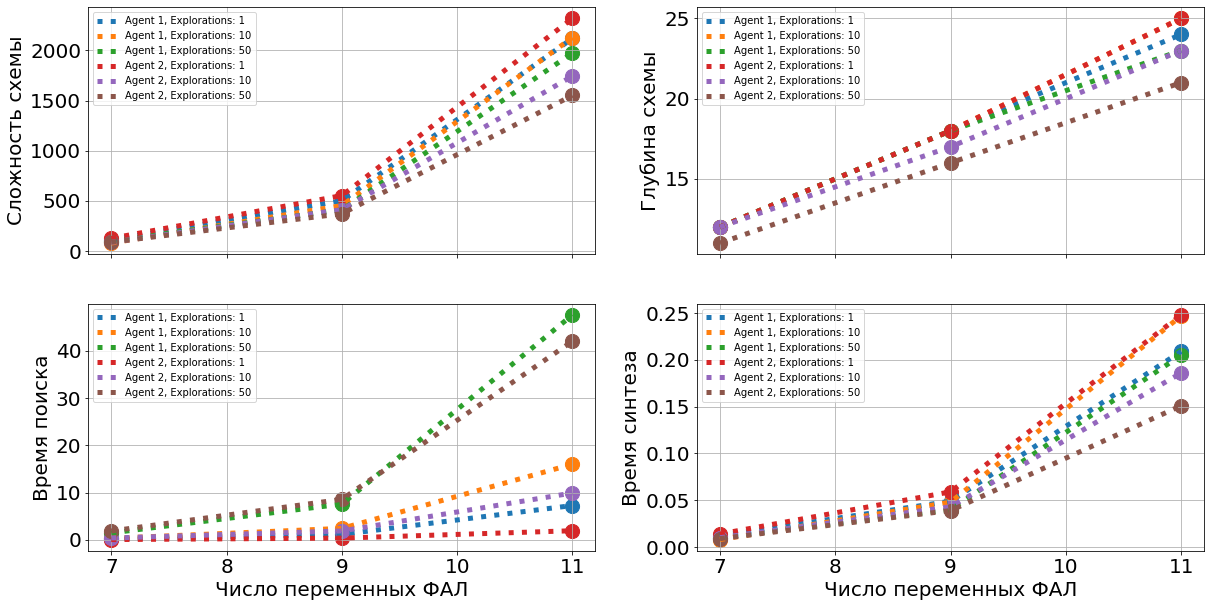

In [11]:
show_super_info(make_super_info(varlist=[7, 9, 11], agent=[1, 2], exploration_number_list=[1, 10, 50]))

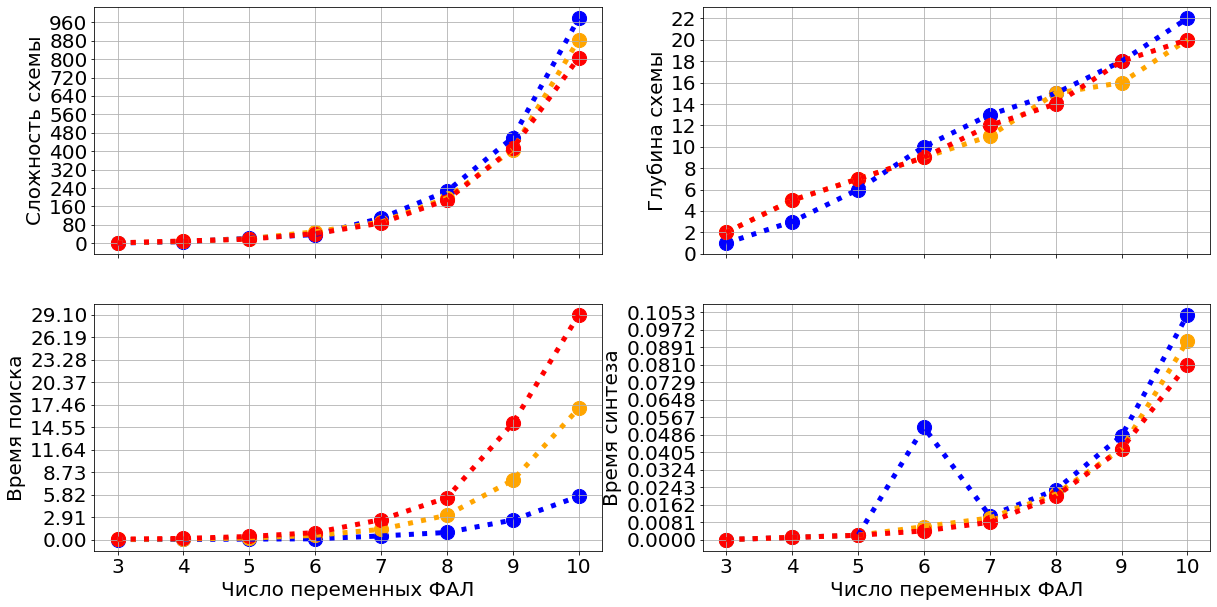

In [27]:
show_info2([make_info([3, 4, 5, 6, 7, 8, 9, 10], exploration_number=10), make_info([3, 4, 5, 6, 7, 8, 9, 10], exploration_number=50), make_info([3, 4, 5, 6, 7, 8, 9, 10], exploration_number=100)])

In [78]:
M = Make_scheme(4, output=False)

Scheme:
( ( ( ( 101 # ( -103 # 104 # 0 ) # 0 ) # ( -101 # -104 # 0 ) # 1 ) # 102 # 0 ) # ( -101 # 103 # 0 ) # 1 ) 
^^^^^^^^^^^^^^^^^^^^
Complexity:  Depth:
7             5
^^^^^^^^^^^^^^^^^^^


In [ ]:
#KA = Karno_Agent(4, 'my_Karno')
KA = Karno_Agent2(8)
print("==============\nKA.extended_field:")
#print(KA.extended_field)
print("^^^^^^^^^^^^^^")
KA.choice_one()
KA.initialize()
print("==============\nKA.curr_coord:")
print(KA.curr_coord)
print("^^^^^^^^^^^^^^")

KA.desasc_sequence(10)
print("==============\nKA.best_edges:")
print(KA.best_edges)
print("^^^^^^^^^^^^^^")

KA.desasc_sequence(100)
print("==============\nKA.best_edges:")
print(KA.best_edges)
print("^^^^^^^^^^^^^^")

KA.desasc_sequence(1000)
print("==============\nKA.best_edges:")
print(KA.best_edges)
print("^^^^^^^^^^^^^^")

KA.micro_ascend(10)
print("==============\nKA.best_edges:")
print(KA.best_edges)
print("^^^^^^^^^^^^^^")

In [ ]:
#KA = Karno_Agent(4, 'my_Karno')
KA = Karno_Agent1(8)
print("==============\nKA.extended_field:")
#print(KA.extended_field)
print("^^^^^^^^^^^^^^")
KA.choice_one()
print("==============\nKA.curr_coord:")
print(KA.curr_coord)
print("^^^^^^^^^^^^^^")
KA.find_first_rect()
print("==============\nKA.curr_edges:")
print(KA.curr_edges)
print("^^^^^^^^^^^^^^")

KA.exploration_sequence(10)
print("==============\nKA.best_edges:")
print(KA.best_edges)
print("^^^^^^^^^^^^^^")

KA.exploration_sequence(100)
print("==============\nKA.best_edges:")
print(KA.best_edges)
print("^^^^^^^^^^^^^^")

KA.exploration_sequence(1000)
print("==============\nKA.best_edges:")
print(KA.best_edges)
print("^^^^^^^^^^^^^^")

In [ ]:
buf = 0
k = 0
while not buf is None and k < 1e3:
    KA = Karno_Agent2(4, to_random=True)
    DNF = KA.Karno_to_vectors(10)
    M = Maj(DNF)
    M.make_element()
    M.put_fal_vector(KA.fal_vector)
    buf = M.test(False, True)
    k += 1
if buf is None:
    print("AAA, NOOO!!!")